In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats

In [2]:
from sklearn.linear_model import BayesianRidge

In [3]:
data = pd.read_csv('SP500Mini.csv', parse_dates=['Date'], index_col='Date', dayfirst=False)
data = data.sort_index()

In [4]:
data['Returns'] = data['Close'][1:].pct_change().dropna()

In [5]:
# Perform the ADF test on the returns
result = adfuller(data['Returns'].dropna())

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation
if result[1] > 0.05:
    print("The series is likely non-stationary (p-value > 0.05).")
else:
    print("The series is likely stationary (p-value <= 0.05).")

ADF Statistic: -10.63825246814946
p-value: 5.006960079978996e-19
The series is likely stationary (p-value <= 0.05).


Rolling Window Bayesian Regression RMSE (Returns): 0.020131597761520237


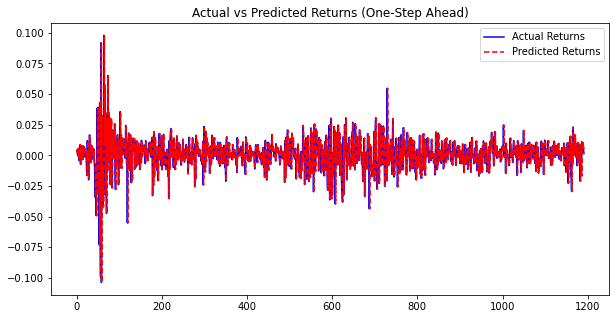

In [11]:
# Set the rolling window size to 63 days (~3 months)
data = data.fillna(method='ffill').dropna()

# Set rolling window size to 63 days (~3 months)
window_size = 63

# Initialize lists to store the true values and predictions
y_true = []
y_pred = []

daily_betas = []

# Rolling window loop on the returns to make one-step ahead predictions
for i in range(window_size, len(data['Returns']) - 1):
    # Extract the window of returns for training
    X_train = np.array(data['Returns'].iloc[i - window_size:i]).reshape(1, -1)
    y_train = np.array([data['Returns'].iloc[i]])

    # Extract the next return as the test target
    y_test = data['Returns'].iloc[i + 1]

    # Train Bayesian Ridge model on the rolling window
    model = BayesianRidge()
    model.fit(X_train, y_train)

    # Predict the next return (one-step-ahead prediction)
    pred = model.predict(X_train)[0]
    y_pred.append(pred)
    y_true.append(y_test)

    # Calculate beta as the slope of the linear regression between predicted and actual returns in the rolling window
    # Regress y_pred (predicted) against y_true (actual returns over window)
    if len(y_pred) > 1:
        beta, intercept, r_value, p_value, std_err = stats.linregress(y_pred[-window_size:], y_true[-window_size:])
        daily_betas.append(beta)
    else:
        daily_betas.append(0)  # Start with a neutral beta if insufficient data


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Rolling Window Bayesian Regression RMSE (Returns): {rmse}")

# Plot the true vs predicted returns
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual Returns', color='blue')
plt.plot(y_pred, label='Predicted Returns', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Returns (One-Step Ahead)')
plt.show()

        Date  Signal
0 2020-12-30      -1
1 2020-12-31      -1
2 2021-01-04      -1
3 2021-01-05      -1
4 2021-01-06       1


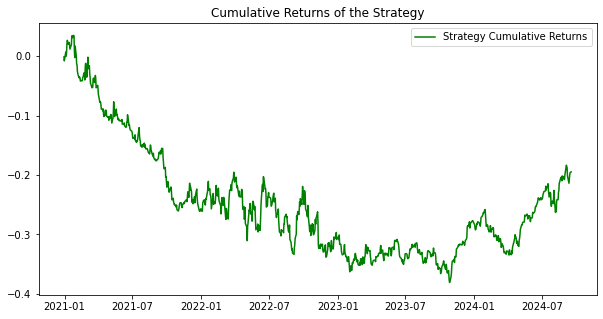

In [10]:
# Convert y_true and y_pred to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
daily_betas = np.array(daily_betas)

# Calculate the 260-day rolling standard deviation of the daily betas
rolling_std_260 = pd.Series(daily_betas).rolling(window=260).std()

# Drop NaN values for beta and rolling standard deviation
daily_betas = daily_betas[~np.isnan(rolling_std_260)]
rolling_std_260 = rolling_std_260.dropna()

# Normalize each daily beta by its 260-day rolling standard deviation
normalized_betas = daily_betas / rolling_std_260.values

# Initialize an empty list for signals
signals = []

# Generate signals based on normalized daily beta
for norm_beta in normalized_betas:
    if norm_beta > 0:  # Threshold for buy
        signals.append(1)  # Buy signal
    elif norm_beta < 0:  # Threshold for sell
        signals.append(-1)  # Sell signal


# Convert signals to a pandas DataFrame for further analysis
signals_df = pd.DataFrame({'Date': data.index[-len(signals):], 'Signal': signals})

# Print the first few signals
print(signals_df.head())

# Calculate strategy returns: Signal * Actual Returns
strategy_returns = pd.Series(signals, index=data.index[-len(signals):]) * data['Returns'].iloc[-len(signals):]

# Calculate cumulative returns of the strategy
cumulative_returns = (strategy_returns + 1).cumprod() - 1

# Plot the cumulative returns of the strategy
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns, label='Strategy Cumulative Returns', color='green')
plt.title('Cumulative Returns of the Strategy')
plt.legend()
plt.show()